In [2]:
!pip install cmfrec

     |████████████████████████████████| 242 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached findblas-0.1.19-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.2.2.post3-cp37-cp37m-linux_x86_64.whl size=4276479 sha256=d002117f706341f955a078d5981cf49dfbbdb8693a34905f89cb234c10dc32ab
  Stored in directory: /root/.cache/pip/wheels/df/91/25/16fddd48bd59883488b3cfae2cee4b2450c94c6dbaea788cc6
Successfully built cmfrec


In [3]:
!pip install threadpoolctl

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "gdrive/MyDrive/Datasets"

Mounted at /content/gdrive
ratings_small.csv		   user_topologycal_properties2.csv
user_topologycal_properties10.csv  user_topologycal_properties3.csv
user_topologycal_properties11.csv  user_topologycal_properties4.csv
user_topologycal_properties12.csv  user_topologycal_properties5.csv
user_topologycal_properties13.csv  user_topologycal_properties6.csv
user_topologycal_properties14.csv  user_topologycal_properties7.csv
user_topologycal_properties15.csv  user_topologycal_properties8.csv
user_topologycal_properties1.csv   user_topologycal_properties9.csv


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from cmfrec import CMF
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import statistics

In [ ]:
df_ratings = pd.read_csv('gdrive/MyDrive/Datasets/ratings_small.csv', usecols=[0, 1, 2])
print("Number of ratings: {0}".format(df_ratings.shape[0]))
user_count = df_ratings['UserId'].nunique()
movie_count = df_ratings["ItemId"].nunique()
print("Number of users: {0}".format(user_count))
print("Number of movies: {0}".format(movie_count))

Number of ratings: 100004
Number of users: 671
Number of movies: 9066


In [ ]:
df_ratings.describe()

,UserId,ItemId,Rating
count,100004.000000,100004.000000,100004.000000
mean,347.011310,12548.664363,3.543608
std,195.163838,26369.198969,1.058064
min,1.000000,1.000000,0.500000
25%,182.000000,1028.000000,3.000000
50%,367.000000,2406.500000,4.000000
75%,520.000000,5418.000000,4.000000
max,671.000000,163949.000000,5.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


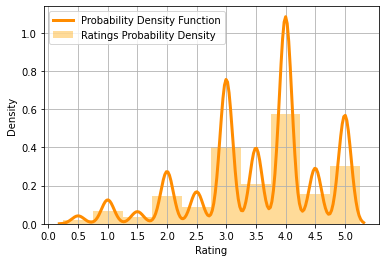

In [ ]:
ratings_list = df_ratings['Rating'].tolist()
d = 1/2
left_of_first_bin = min(ratings_list) - d/2
right_of_last_bin = max(ratings_list) + d/2
b = np.arange(left_of_first_bin, right_of_last_bin + d, d)
plt.clf()
sns.distplot(ratings_list, bins=b, hist=True, kde=True, color='darkorange', kde_kws={'linewidth': 3}, hist_kws={'color':'orange'})
plt.xlabel("Rating")
plt.xticks(np.arange(0, 5.5, 0.5))
plt.legend(labels=['Probability Density Function','Ratings Probability Density'])
plt.grid()
plt.show()

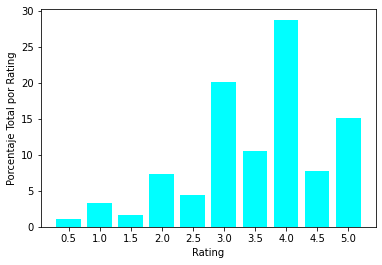

In [ ]:
p = df_ratings.groupby('Rating')['Rating'].agg(['count'])
ratings = []
for i in np.arange(0.5, 5.5, 0.5):
    ratings.append(str(i))
rating_percentage = []
for i in range(len(p)):
    rating_percentage.append(p.iloc[i][0]*100 / p.sum()[0])

plt.clf()
plt.bar(ratings, rating_percentage, color="cyan")
plt.xlabel('Rating')
plt.ylabel('Porcentaje Total por Rating')
plt.show()

In [ ]:
#Grid Search
rmse_min = np.inf
ans = None
k_values = [10, 20, 30, 50, 100] #latent factors
lamda_values = [0.1, 1, 10, 50] #regularization parameter

for k_ in k_values:
  for l_ in lamda_values:
    HOLDOUT = 10
    h_rmse = []
    for i in range(HOLDOUT):
      #Train-Test Split Dataset
      users_train, users_test = train_test_split(df_ratings.UserId.unique(), test_size=0.2)
      items_train, items_test = train_test_split(df_ratings.ItemId.unique(), test_size=0.2)
      ratings_train, ratings_test = train_test_split(df_ratings.loc[df_ratings.UserId.isin(users_train) & df_ratings.ItemId.isin(items_train)], test_size=0.2)
      #Fit Model
      model = CMF(method="als", k=k_, lambda_=l_, user_bias=True, verbose=False).fit(ratings_train)
      #Predictions
      predictions = model.predict(ratings_test.UserId, ratings_test.ItemId)
      #RMSE
      rmse = metrics.mean_squared_error(ratings_test.Rating, predictions, squared=True)
      h_rmse.append(rmse)

    mean_rmse = np.mean(h_rmse)
    if mean_rmse < rmse_min:
      rmse_min = mean_rmse
      ans = [k_, l_]

print("The best RMSE is {0} and is obtained with the parameters k={1} and lambda={2}".format(rmse_min, ans[0], ans[1]))

The best RMSE is 0.8073276837948882 and is obtained with the parameters k=20 and lambda=10


# Recommendation without topological properties

In [ ]:
HOLDOUT = 20
h_rmse = []
h_mae = []
h_r2 = []

for i in range(HOLDOUT):
  #Train-Test Split Dataset
  users_train, users_test = train_test_split(df_ratings.UserId.unique(), test_size=0.2)
  items_train, items_test = train_test_split(df_ratings.ItemId.unique(), test_size=0.2)
  ratings_train, ratings_test = train_test_split(df_ratings.loc[df_ratings.UserId.isin(users_train) & df_ratings.ItemId.isin(items_train)], test_size=0.2)
  
  #Fit Model
  model = CMF(method="als", k=ans[0], lambda_=ans[1], user_bias=True, verbose=False).fit(ratings_train)

  #Predictions
  predictions = model.predict(ratings_test.UserId, ratings_test.ItemId)

  #Metrics
  rmse = metrics.mean_squared_error(ratings_test.Rating, predictions, squared=True)
  mae = metrics.mean_absolute_error(ratings_test.Rating, predictions)
  r2 = metrics.r2_score(ratings_test.Rating, predictions)
  h_rmse.append(rmse)
  h_mae.append(mae)
  h_r2.append(r2)

#Algorithm analysis
mean_h_rmse = statistics.mean(h_rmse)
mean_h_mae = statistics.mean(h_mae)
mean_h_r2 = statistics.mean(h_r2)
stdev_h_rmse = statistics.stdev(h_rmse)
stdev_h_mae = statistics.stdev(h_mae)
stdev_h_r2 = statistics.stdev(h_r2)
print("Holdout Report")
print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse,mean_h_mae,mean_h_r2))
print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))

Holdout Report
Mean of RMSE, MAE, R2: 0.8983599909853734, 0.712689746957873, 0.19643763918680118
Standard deviation of RMSE, MAE, R2: 0.1867005100719084, 0.04278999308344076, 0.17153937328550417


# Recommendation using topological properties (CMF)


In [ ]:
for i in range(15):

  filename = "gdrive/MyDrive/Datasets/user_topologycal_properties{0}.csv".format(i+1)
  df_users = pd.read_csv(filename)
  #Normalize values
  df_users['degree'] = preprocessing.scale(df_users['degree'])
  df_users['betweenness'] = preprocessing.scale(df_users['betweenness'])
  df_users['community'] = preprocessing.scale(df_users['community'])
  df_users['eccentricity'] = preprocessing.scale(df_users['eccentricity'])
  df_users['farness'] = preprocessing.scale(df_users['farness'])
  
  HOLDOUT = 12
  h_rmse = []
  h_mae = []
  h_r2 = []
  for j in range(HOLDOUT):
    #Train-Test Split Dataset
    users_train, users_test = train_test_split(df_ratings.UserId.unique(), test_size=0.2)
    items_train, items_test = train_test_split(df_ratings.ItemId.unique(), test_size=0.2)
    ratings_train, ratings_test = train_test_split(df_ratings.loc[df_ratings.UserId.isin(users_train) & df_ratings.ItemId.isin(items_train)], test_size=0.2)
    user_attr_train = df_users.loc[df_users.UserId.isin(ratings_train.UserId.unique())]

    #Fit Model
    m_collective = CMF(method="als", k=ans[0], lambda_=ans[1], user_bias=True, verbose=False).fit(X=ratings_train, U=user_attr_train)

    #Predictions
    predictions = m_collective.predict(ratings_test.UserId, ratings_test.ItemId)

    #Metrics
    rmse = metrics.mean_squared_error(ratings_test.Rating,predictions,squared=True)
    mae = metrics.mean_absolute_error(ratings_test.Rating,predictions)
    r2 = metrics.r2_score(ratings_test.Rating,predictions)
    h_rmse.append(rmse)
    h_mae.append(mae)
    h_r2.append(r2)

  #Algorithm analysis
  mean_h_rmse = statistics.mean(h_rmse)
  mean_h_mae = statistics.mean(h_mae)
  mean_h_r2 = statistics.mean(h_r2)
  stdev_h_rmse = statistics.stdev(h_rmse)
  stdev_h_mae = statistics.stdev(h_mae)
  stdev_h_r2 = statistics.stdev(h_r2)
  print("Holdout Report for Model {0}".format(i+1))
  print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse,mean_h_mae,mean_h_r2))
  print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))
  print()

Holdout Report for Model 1
Mean of RMSE, MAE, R2: 0.8831016158490022, 0.7112652612442337, 0.21317228300978086
Standard deviation of RMSE, MAE, R2: 0.13910551879393898, 0.035696346561224196, 0.12003967174510714

Holdout Report for Model 2
Mean of RMSE, MAE, R2: 0.8431644288003897, 0.6993678673928465, 0.251542177286142
Standard deviation of RMSE, MAE, R2: 0.10183378997600456, 0.02958118420451844, 0.09775006093783932

Holdout Report for Model 3
Mean of RMSE, MAE, R2: 0.8841900378590697, 0.7121669537891142, 0.21285518761304908
Standard deviation of RMSE, MAE, R2: 0.1269377014641381, 0.03735159725765852, 0.11212102176484535

Holdout Report for Model 4
Mean of RMSE, MAE, R2: 0.8326077124316996, 0.6950180491050036, 0.2502668574971197
Standard deviation of RMSE, MAE, R2: 0.10348020816151911, 0.03205081578378015, 0.08347415064615618

Holdout Report for Model 5
Mean of RMSE, MAE, R2: 0.8549444312890052, 0.7017091342324339, 0.2328050802797905
Standard deviation of RMSE, MAE, R2: 0.118540968978033

# **Results**

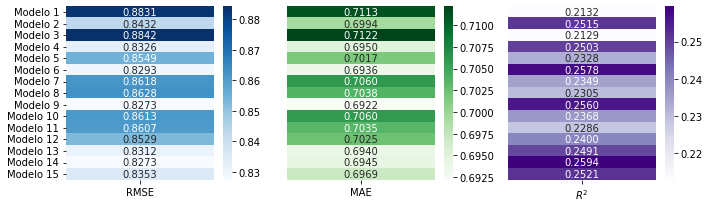

In [15]:
metrics_array = np.array(
    [[0.8831016158490022, 0.7112652612442337, 0.21317228300978086],
    [0.8431644288003897, 0.6993678673928465, 0.251542177286142],
    [0.8841900378590697, 0.7121669537891142, 0.21285518761304908],
    [0.8326077124316996, 0.6950180491050036, 0.2502668574971197],
    [0.8549444312890052, 0.7017091342324339, 0.2328050802797905],
    [0.82934217031758, 0.693580732388378, 0.2577949581134487],
    [0.8617622287753627, 0.7060396452268201, 0.23492076741232407],
    [0.8628286733742115, 0.7038305314887368, 0.23045149079669036],
    [0.8273345854436961, 0.6921750152452244, 0.2559871523800278],
    [0.8612745602012266, 0.7059840130747483, 0.2367590977630544],
    [0.8606823130826213, 0.703525468437611, 0.2286399606725255],
    [0.8529436663606957, 0.7024779656804425, 0.23996124605737107],
    [0.8311947129751686, 0.6940413187698704, 0.24914672377363306],
    [0.8273406659607411, 0.6944736540231924, 0.25941533002396966],
    [0.8352539005583732, 0.6968820920109109, 0.2520893614347855]]
)

index_values = ['Modelo {0}'.format(i+1) for i in range(15)]
column_values = ['RMSE', 'MAE', '$R^2$']
df = pd.DataFrame(data=metrics_array, index=index_values, columns=column_values)

#Results

cm = ['Blues', 'Greens', 'Purples']
f, axs = plt.subplots(1, df.columns.size, figsize=(10, 3))
for i, (s, a, c) in enumerate(zip(df.columns, axs, cm)):
    sns.heatmap(np.array([df[s].values]).T, yticklabels=df.index, xticklabels=[s], annot=True, fmt='.4f', ax=a, cmap=c)
    if i>0:
        a.yaxis.set_ticks([])
f.tight_layout()   
f.savefig('results.jpg', dpi=400)

In [ ]:
alphas_expo = [1*10**-4, 3*10**-5, 1*10**-5, 3*10**-6, 1*10**-7]
alphas_pow = [7.5, 8.5, 9, 9.5, 11]
alphas_ray = [1*10**-10, 2*10**-11, 3*10**-12, 1*10**-12, 1*10**-14]

rmse_data = df['RMSE'].tolist()
rmse_expo = rmse_data[0:5]
rmse_pow = rmse_data[5:10]
rmse_ray = rmse_data[10:15]

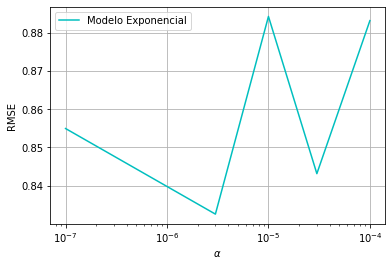

In [ ]:
plt.plot(alphas_expo, rmse_expo, "c", label='Modelo Exponencial')
plt.xscale('log')
plt.ylabel("RMSE")
plt.xlabel("$\\alpha$")
plt.legend()
plt.grid()
plt.savefig('expo.jpg', dpi=400)

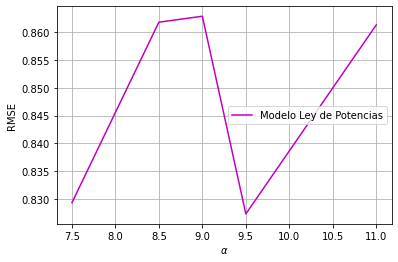

In [ ]:
plt.clf()
plt.plot(alphas_pow, rmse_pow, "m", label='Modelo Ley de Potencias')
plt.ylabel("RMSE")
plt.xlabel("$\\alpha$")
plt.legend()
plt.grid()
plt.savefig('pow.jpg', dpi=400)

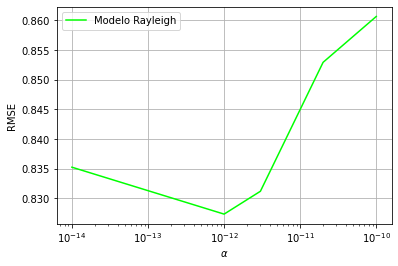

In [ ]:
plt.clf()
plt.plot(alphas_ray, rmse_ray, "lime", label='Modelo Rayleigh')
plt.xscale('log')
plt.ylabel("RMSE")
plt.xlabel("$\\alpha$")
plt.legend()
plt.grid()
plt.savefig('ray.jpg', dpi=400)

In [ ]:
mae_data = df['MAE'].tolist()
mae_expo = mae_data[0:5]
mae_pow = mae_data[5:10]
mae_ray = mae_data[10:15]

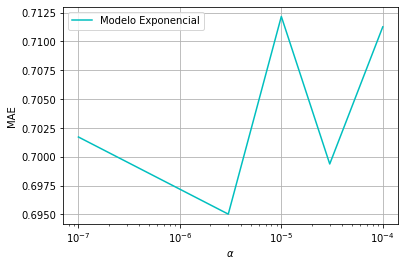

In [ ]:
plt.plot(alphas_expo, mae_expo, "c", label='Modelo Exponencial')
plt.xscale('log')
plt.ylabel("MAE")
plt.xlabel("$\\alpha$")
plt.legend()
plt.grid()
plt.savefig('expo2.jpg', dpi=400)

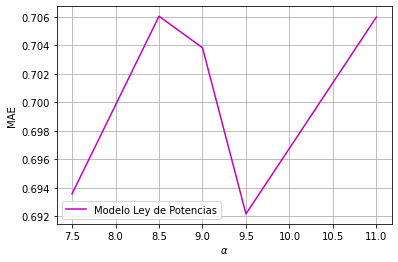

In [ ]:
plt.clf()
plt.plot(alphas_pow, mae_pow, "m", label='Modelo Ley de Potencias')
plt.ylabel("MAE")
plt.xlabel("$\\alpha$")
plt.legend()
plt.grid()
plt.savefig('pow2.jpg', dpi=400)

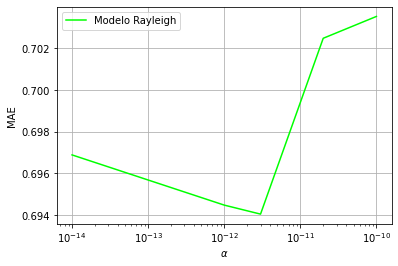

In [ ]:
plt.clf()
plt.plot(alphas_ray, mae_ray, "lime", label='Modelo Rayleigh')
plt.xscale('log')
plt.ylabel("MAE")
plt.xlabel("$\\alpha$")
plt.legend()
plt.grid()
plt.savefig('ray2.jpg', dpi=400)

In [17]:
r2_data = df['$R^2$'].tolist()
r2_expo = r2_data[0:5]
r2_pow = r2_data[5:10]
r2_ray = r2_data[10:15]

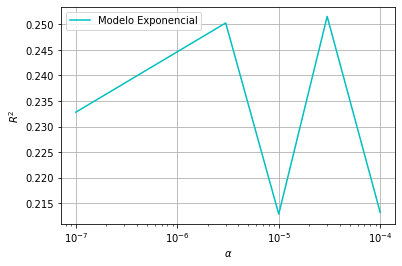

In [ ]:
plt.plot(alphas_expo, r2_expo, "c", label='Modelo Exponencial')
plt.xscale('log')
plt.ylabel("$R^2$")
plt.xlabel("$\\alpha$")
plt.legend()
plt.grid()
plt.savefig('expo3.jpg', dpi=400)

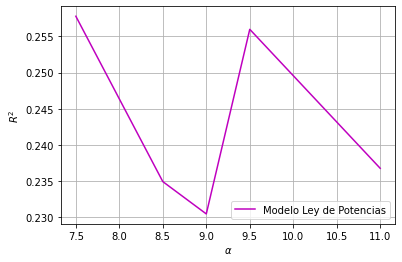

In [ ]:
plt.clf()
plt.plot(alphas_pow, r2_pow, "m", label='Modelo Ley de Potencias')
plt.ylabel("$R^2$")
plt.xlabel("$\\alpha$")
plt.legend()
plt.grid()
plt.savefig('pow3.jpg', dpi=400)

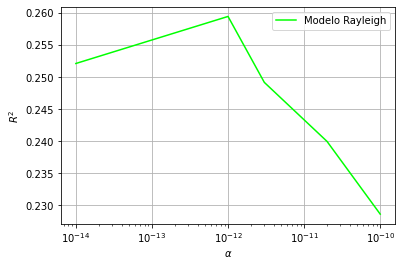

In [ ]:
plt.clf()
plt.plot(alphas_ray, r2_ray, "lime", label='Modelo Rayleigh')
plt.xscale('log')
plt.ylabel("$R^2$")
plt.xlabel("$\\alpha$")
plt.legend()
plt.grid()
plt.savefig('ray3.jpg', dpi=400)